In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import cv2
import numpy as np

import os
import shutil
from sklearn.model_selection import train_test_split



/opt/anaconda3/envs/cv/lib/python3.9/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# 데이터 폴더 경로 설정
data_dir = '../data/augmented_data'
train_dir = '../data/augmented_train'
val_dir = '../data/augmented_val'

In [3]:
# 데이터 폴더 생성
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [4]:
# 클래스별 폴더 분리
classes = ['G2', 'BLDC-400-f', 'BLDC-400-b', 'CN7']

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    images = os.listdir(class_path)
    train_images, valid_images = train_test_split(images, test_size=0.2, random_state=42)

    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_class_dir, img))
    for img in valid_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_class_dir, img))

/var/folders/2p/670k4kqs5qx3_9gpj5s5jfxh0000gn/T/ipykernel_58247/3139061466.py:37: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(


Selected image paths:
G2: ../data/augmented_data/G2/G2_aug_0.png
BLDC-400-f: ../data/augmented_data/BLDC-400-f/BLDC-400-f_aug_1.png
BLDC-400-b: ../data/augmented_data/BLDC-400-b/BLDC-400-b_aug_91.png
CN7: ../data/augmented_data/CN7/CN7_aug_16.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8352942].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7803922].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


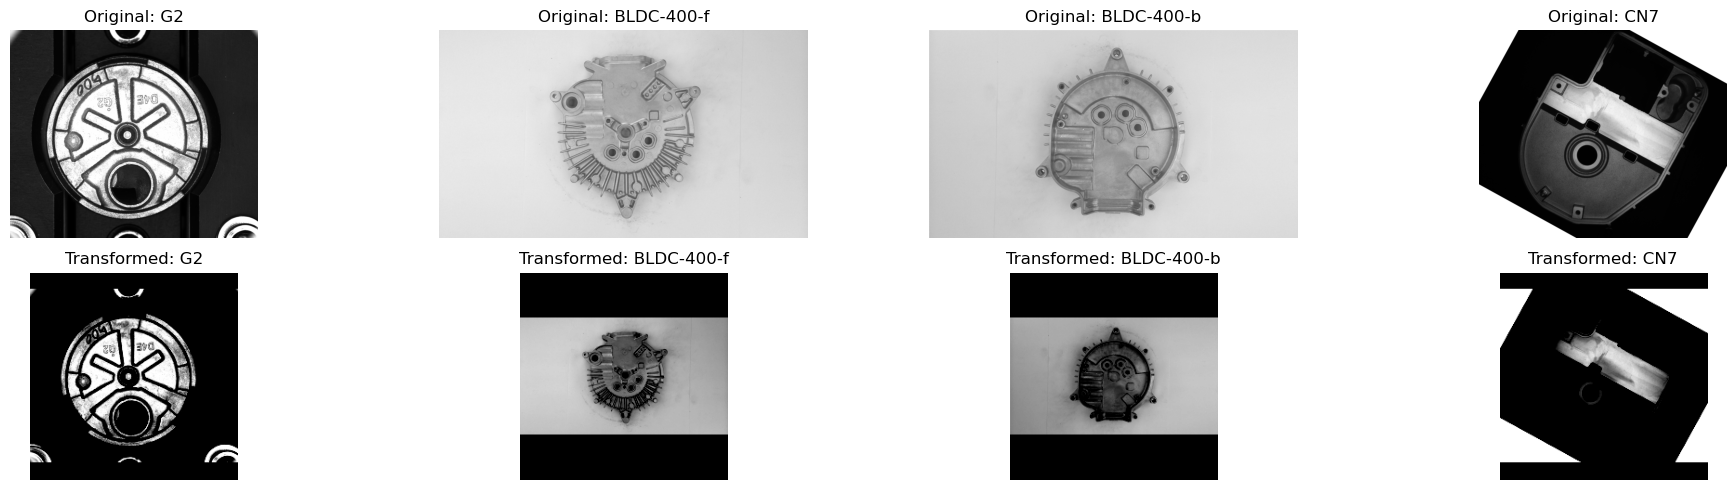

In [5]:
def resize_with_aspect_ratio(image, target_size):
    # 원본 크기
    h, w = image.shape[:2]
    # 가로, 세로 비율 계산
    aspect = w / h

    # 목표 크기에 맞춰 비율 조정
    if aspect > 1:  # 가로가 더 긴 경우
        new_w = target_size[0]
        new_h = int(new_w / aspect)
    else:  # 세로가 더 긴 경우
        new_h = target_size[1]
        new_w = int(new_h * aspect)

    # 리사이즈
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # 패딩을 위한 빈 이미지 생성
    delta_w = target_size[0] - new_w
    delta_h = target_size[1] - new_h
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    # 패딩 추가 (검정색 배경)
    padded = cv2.copyMakeBorder(
        resized,
        top, bottom, left, right,
        cv2.BORDER_CONSTANT,
        value=[0, 0, 0]
    )
    return padded

# 목표 크기
target_size = (224, 224)

transforms = A.Compose([
    A.Lambda(
        image=lambda x, **kwargs: resize_with_aspect_ratio(x, target_size)
    ),
    A.ToGray(p=1.0),  # RGB를 흑백으로 변환
    A.Normalize(
        mean=[0.5],
        std=[0.5]
    ),
    ToTensorV2()
])

class AlbumentationsTransform:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        # OpenCV 이미지로 변환 후 Albumentations 적용
        img = np.array(img)  # PIL -> Numpy
        transformed = self.transforms(image=img)
        return transformed['image']


#처리 결과 확인
def visualize_all_classes(class_image_paths):
    plt.figure(figsize=(20, 5))
    for idx, (class_name, image_path) in enumerate(class_image_paths.items(), 1):
        # 이미지 경로 확인
        if not image_path:
            print(f"Warning: No image path for class {class_name}")
            continue
        # 원본 이미지 읽기
        original = cv2.imread(image_path)
        if original is None:
            print(f"Warning: Could not read image at {image_path}")
            continue
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        
        # 변환 적용
        transformed = transforms(image=original)['image']
        transformed = transformed.permute(1, 2, 0).numpy()

        # 각 클래스별로 2개의 subplot (원본/변환)
        plt.subplot(2, 4, idx)
        plt.imshow(original)
        plt.title(f'Original: {class_name}')
        plt.axis('off')
        plt.subplot(2, 4, idx+4)
        plt.imshow(transformed)
        plt.title(f'Transformed: {class_name}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

paths = {class_name: [] for class_name in classes}

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.exists(class_path):
        images = os.listdir(class_path)
        if os.path.exists(class_path):
            paths[class_name] = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))]
        else:
            print(f"Warning: Directory {class_path} does not exist.")

# 각 클래스별 첫 번째 이미지 선택
class_images = {}

for class_name in classes:
    try:
        class_images[class_name] = paths[class_name][0] if paths[class_name] else None
    except IndexError as e:
        print(f"Error accessing path for {class_name}: {e}")
        class_images[class_name] = None

# 실행 전 경로 확인
print("Selected image paths:")
for class_name, path in class_images.items():
    print(f"{class_name}: {path}")

visualize_all_classes(class_images)

In [6]:
train_transforms = AlbumentationsTransform(A.Compose([
    A.Lambda(image=lambda x, **kwargs: resize_with_aspect_ratio(x, target_size)),
    A.ToGray(p=1.0),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2()
]))

/var/folders/2p/670k4kqs5qx3_9gpj5s5jfxh0000gn/T/ipykernel_58247/2469233318.py:2: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: resize_with_aspect_ratio(x, target_size)),


In [7]:
# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(val_dir, transform=train_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [8]:
# ResNet 모델 사용
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(classes))

/opt/anaconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [10]:
# 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# 훈련 함수
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [12]:
# 검증 함수
def validate(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / len(valid_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
import time

# 훈련 루프
epochs = 5
start_time = time.time()

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc = validate(model, valid_loader, criterion, device)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.4f}")

end_time = time.time()
training_time = end_time - start_time
print(f"Total Training Time: {training_time:.2f} seconds")

In [14]:
torch.save(model.state_dict(), '../models/resnet_101.pth')